# Data Challenge 10 — MLR Interpretation with Adjusted R² (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build **3 MLR models** with different feature sets to predict a numeric target, then compare **Adjusted R²** and **p-values** to select the better model and justify it in business terms.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- TLC HVFHV data dictionary (columns/meaning): https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf  
- statsmodels OLS: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (attributes like `rsquared_adj`, `pvalues`): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html  

### Pseudocode Plan
1) **Load CSV** → preview columns/shape; confirm target & candidate predictors exist.  
2) **Assign Y + Xs** (start small, add features with a hypothesis). Coerce **just these columns** to numeric.  
3) **Light prep:** derive `trip_time_minutes` from `trip_time` (seconds); convert flags (`shared_request_flag`, `wav_request_flag`) to 0/1 if present.  
4) **Model sets (3 total):**  
   - **Model A (parsimonious).**  
   - **Model B (adds one meaningful predictor).**  
   - **Model C (adds 1–2 more, e.g., flags).  
5) **Add intercept** and **fit** each with OLS on the same rows.  
6) **Record metrics:** `rsquared_adj`, coefficient table, and **p-values**.  
7) **Compare:** Prefer higher **Adjusted R²** and keep an eye on **p-values** (and signs/units).  
8) **Interpretation:** Write unit-based sentences **holding others constant**.  
9) **Selection rationale:** Pick the simplest model that improves **Adjusted R²** and 


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/FHV_072023copy.csv'
df = pd.read_csv(path)
df

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_55083/440977791.py:2: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0005,B03406,NaN,07/01/2023 05:34:30 PM,NaN,07/01/2023 05:37:48 PM,07/01/2023 05:44:45 PM,158,68,1.2660,...,1.3500,2.7500,0.0000,2.0000,5.5700,N,N,N,N,False
1,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:53 PM,07/01/2023 05:37:15 PM,07/01/2023 05:55:15 PM,162,234,2.3500,...,1.5200,2.7500,0.0000,3.2800,13.3800,N,N,NaN,N,False
2,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:35:17 PM,07/01/2023 05:35:52 PM,07/01/2023 05:44:27 PM,161,163,0.8100,...,0.4900,2.7500,0.0000,0.0000,5.9500,N,N,NaN,N,False
3,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:37:39 PM,07/01/2023 05:39:35 PM,07/01/2023 06:23:02 PM,122,229,15.4700,...,5.1700,2.7500,0.0000,0.0000,54.4600,N,N,NaN,N,True
4,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:06 PM,07/01/2023 05:36:39 PM,07/01/2023 05:45:06 PM,67,14,1.5200,...,0.8500,0.0000,0.0000,3.0000,7.0100,N,N,NaN,N,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8324586,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:37:55 PM,07/15/2023 05:38:09 PM,07/15/2023 06:03:58 PM,221,23,8.2700,...,2.3000,0.0000,0.0000,0.0000,25.4300,N,N,NaN,N,False
8324587,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:39:08 PM,07/15/2023 05:39:29 PM,07/15/2023 05:50:14 PM,162,43,1.8300,...,1.0500,2.7500,0.0000,5.0000,8.4600,N,N,NaN,N,False
8324588,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:41:44 PM,07/15/2023 05:41:44 PM,07/15/2023 06:03:33 PM,249,170,2.2200,...,2.3000,2.7500,0.0000,0.0000,15.6800,N,N,NaN,N,False
8324589,HV0003,B03404,B03404,07/15/2023 05:34:30 PM,07/15/2023 05:39:00 PM,07/15/2023 05:39:04 PM,07/15/2023 05:54:04 PM,80,198,3.0500,...,1.3500,0.0000,0.0000,0.0000,12.6600,N,N,NaN,N,False


### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [3]:
df.dtypes

#trip_time is an object??? (bruh)

hvfhs_license_num        object
dispatching_base_num     object
originating_base_num     object
request_datetime         object
on_scene_datetime        object
pickup_datetime          object
dropoff_datetime         object
PULocationID              int64
DOLocationID              int64
trip_miles              float64
trip_time                object
base_passenger_fare      object
tolls                   float64
bcf                     float64
sales_tax               float64
congestion_surcharge    float64
airport_fee             float64
tips                    float64
driver_pay               object
shared_request_flag      object
shared_match_flag        object
access_a_ride_flag       object
wav_request_flag         object
wav_match_flag             bool
dtype: object

In [4]:
# some cleaning

# converting columns to numeric (with cleaning)
num_columns = ['trip_miles', 'trip_time', 'base_passenger_fare']
for x in num_columns:
    df[x] = pd.to_numeric(
        df[x].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)
df.dtypes

hvfhs_license_num        object
dispatching_base_num     object
originating_base_num     object
request_datetime         object
on_scene_datetime        object
pickup_datetime          object
dropoff_datetime         object
PULocationID              int64
DOLocationID              int64
trip_miles              float64
trip_time                 int64
base_passenger_fare     float64
tolls                   float64
bcf                     float64
sales_tax               float64
congestion_surcharge    float64
airport_fee             float64
tips                    float64
driver_pay               object
shared_request_flag      object
shared_match_flag        object
access_a_ride_flag       object
wav_request_flag         object
wav_match_flag             bool
dtype: object

In [5]:
# creating new column for time in minutes (I like it better)
df['trip_time_mins'] = df['trip_time']/60

In [ ]:
# Our flag variable, which I convert to numeric

match_int = []
for a in df['shared_match_flag']:
    if a == 'N':
        match_int.append(0)     # 0 --> No
    else:
        match_int.append(1)     # 1 --> Yes

df['shared_match_flag_num'] = match_int

display(df['shared_match_flag_num'].value_counts())
display(df['shared_match_flag'].value_counts())

shared_match_flag_num
0    8264814
1      59777
Name: count, dtype: int64

shared_match_flag
N    8264814
Y      59777
Name: count, dtype: int64

In [34]:
# our base y
y = df['base_passenger_fare']

print(y.isna().sum())
display(y.describe())

0


count   8,324,591.0000
mean           23.7703
std            20.5465
min           -23.5000
25%            11.5700
50%            17.9100
75%            28.8500
max         2,844.2500
Name: base_passenger_fare, dtype: float64

### Step 3 — Define Three Model Specs (A, B, C)
Example models you can chose any models you want as long as Model A has one term, Model B two terms, etc.

- **Model A:** distance only.  
- **Model B:** distance + time (minutes).  
- **Model C:** distance + time + flags (whichever exist).

In [8]:
# Model A - variable separated: distance only
XA = sm.add_constant(df['trip_miles'])

In [9]:
# Model B - our variables together: distance + time
XB = sm.add_constant(df[['trip_miles', 'trip_time_mins']])

In [10]:
# Model C - variables together: distance + time + flag
XC = sm.add_constant(df[['trip_miles', 'trip_time_mins', 'shared_match_flag_num']])
XC.describe()

,const,trip_miles,trip_time_mins,shared_match_flag_num
count,"8,324,591.0000","8,324,591.0000","8,324,591.0000","8,324,591.0000"
mean,1.0000,5.0758,19.0384,0.0072
std,0.0000,5.9688,13.4716,0.0844
min,1.0000,0.0000,0.0167,0.0000
25%,1.0000,1.6100,9.8000,0.0000
50%,1.0000,3.0400,15.6000,0.0000
75%,1.0000,6.3100,24.3333,0.0000
max,1.0000,486.7300,726.5667,1.0000


In [35]:
display(XA.shape)
display(XB.shape)
display(XC.shape)
display(y.shape)

(8324591, 2)

(8324591, 3)

(8324591, 4)

(8324591,)

<Axes: xlabel='trip_time_mins', ylabel='trip_miles'>

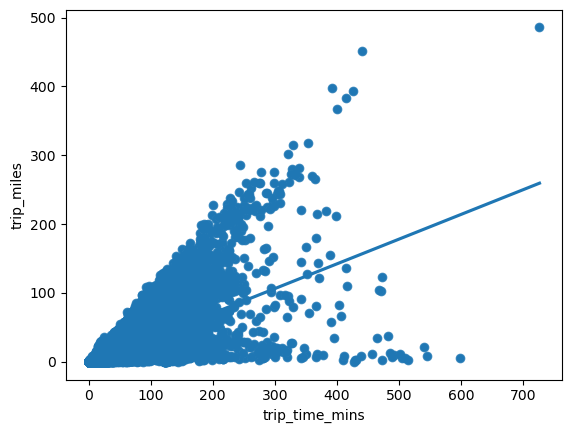

In [11]:
# plotted for initial view
sns.scatterplot(df, x='trip_time_mins', y='trip_miles')
sns.regplot(df, x='trip_time_mins', y='trip_miles')

In [36]:
# Model A
XA_train, XA_test, yA_train, yA_test = train_test_split(XA, y, train_size=0.7, test_size=0.3, random_state=40)

# Model B
XB_train, XB_test, yB_train, yB_test = train_test_split(XB, y, train_size=0.7, test_size=0.3, random_state=41)

# Model C
XC_train, XC_test, yC_train, yC_test = train_test_split(XC, y, train_size=0.7, test_size=0.3, random_state=42)

### Step 4 — Fit Each Model (with intercept) and Collect Adjusted R² & p-values


In [37]:
Model_A = sm.OLS(yA_train, XA_train).fit()

Model_B = sm.OLS(yB_train, XB_train).fit()

Model_C = sm.OLS(yC_train, XC_train).fit()


### Step 5 — Inspect Full Summaries (coefficients, p-values, diagnostics)

- Print summaries for the top 1–2 models by **Adjusted R²**.
- Write **unit-based** interpretations “holding others constant.”

In [39]:
print("------------------Model A: Distance------------------")
display(Model_A.summary())

print("------------------Model B: Distance + Time------------------")
display(Model_B.summary())

print("------------------Model C: Distance + Time + Flag------------------")
display(Model_C.summary())

------------------Model A: Distance------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     base_passenger_fare   R-squared:                       0.809
Model:                             OLS   Adj. R-squared:                  0.809
Method:                  Least Squares   F-statistic:                 2.473e+07
Date:                 Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                         11:54:26   Log-Likelihood:            -2.1060e+07
No. Observations:              5827213   AIC:                         4.212e+07
Df Residuals:                  5827211   BIC:                         4.212e+07
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0643      0.005   1652.712      0.000       8.055       8.074
trip_miles     3.0940      0.001   4973.421      0.000       3.093       3.095
==============================================================================
Omnibus:                  6686437.804   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11599025573.640
Skew:                           5.007   Prob(JB):                         0.00
Kurtosis:                     221.338   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------Model B: Distance + Time------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     base_passenger_fare   R-squared:                       0.843
Model:                             OLS   Adj. R-squared:                  0.843
Method:                  Least Squares   F-statistic:                 1.563e+07
Date:                 Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                         11:54:26   Log-Likelihood:            -2.0494e+07
No. Observations:              5827213   AIC:                         4.099e+07
Df Residuals:                  5827210   BIC:                         4.099e+07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3408      0.006    548.396      0.000       3.329       3.353
trip_miles         2.2115      0.001   2284.763      0.000       2.210       2.213
trip_time_mins     0.4835      0.000   1127.114      0.000       0.483       0.484
==============================================================================
Omnibus:                  8195664.496   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      72529166879.651
Skew:                           7.085   Prob(JB):                         0.00
Kurtosis:                     549.368   Cond. No.                         44.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

------------------Model C: Distance + Time + Flag------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     base_passenger_fare   R-squared:                       0.846
Model:                             OLS   Adj. R-squared:                  0.846
Method:                  Least Squares   F-statistic:                 1.064e+07
Date:                 Wed, 19 Nov 2025   Prob (F-statistic):               0.00
Time:                         11:54:26   Log-Likelihood:            -2.0431e+07
No. Observations:              5827213   AIC:                         4.086e+07
Df Residuals:                  5827209   BIC:                         4.086e+07
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.3307      0.006    552.289      0.000       3.319       3.342
trip_miles                2.1951      0.001   2289.734      0.000       2.193       2.197
trip_time_mins            0.4928      0.000   1157.646      0.000       0.492       0.494
shared_match_flag_num   -11.7313      0.040   -295.125      0.000     -11.809     -11.653
==============================================================================
Omnibus:                  7323149.390   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      24814879871.441
Skew:                           5.818   Prob(JB):                         0.00
Kurtosis:                     322.480   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 6 — Interpretations (write below)

Using the **best model’s** coefficients interpret each coefficient using markdown

### **Model A: Distance**

- **R-Squared, Adj. R-Squared** = 0.809

- **Constant Coefficient** = 8.0643
    - *CI* = 8.055 - 8.074

- `trip_miles` **Coefficient** = 3.0940
    - *CI* = 3.093 - 3.095

<br>

- `trip_miles` high t-score, low p-value
- **Durbin-Watson**: 2.000

***

<div align='center'>

Based on our statistics, we can see that the trip distance of each ride appears to have a large role in the variation of passenger fares. 

Our constant tells us that a trip at 0 miles starts with a passenger fare of ~$8.06 though this constant does not really make much sense and acts more as a baseline for our model.

Our coefficient for trip miles, however, tells us that for each +1 mile, we roughly see an increase of ~$3.09. Furthermore, we are 95% confident that it falls roughly between $3.09 - $3.10, which tells us that our model is particularly precise.

Finally, our low p-value for trip miles tells us that its change in passenger fares is statistically significant.
</div>

***

### **Model B: Distance + Time**

- **R-Squared, Adj. R-Squared** = 0.843

- **Constant Coefficient** = 3.3408
    - *CI* = 3.329 - 3.53

- `trip_miles` **Coefficient** = 2.2115
    - *CI* = 2.210 - 2.213

- `trip_time_mins` **Coefficient** = 0.4835
    - 0.483 - 0.484

<br>

- `trip_miles` high t-score, low p-value
- `trip_time_mins` medium t-score, low p-value
- **Durbin-Watson**: 2.000

***

Our Adj. R-Squared here is high and shows no anomaly in comparison to R-Squared, telling us that trip time is adding to the model and not penalizing it for being useless.

Our constant tells us that a trip starting at 0 miles *AND* at 0 minutes will have a base fare of ~$3.34, though this acts more as a baseline rather than a meaningful insight.

Our coefficients add more insight:
- For every +1 mile, our fare increases by ~$2.21. Our confidence intervals tell us that this number is precise, too.

- For every +1 minute on the trip, our fare increases by ~$0.48. This number is highly precise, as indicated by our confidence intervals.

Trip miles also seems have a large, positive relationship with passenger fare, whereas trip time has a medium, but still positive, relationship with passenger fare, as told by our t-scores.

Lastly, our low p-values for both variables tell us that they are both statistically significant factors of the variation of trip fares.

***

### **Model C: Distance + Time + Flag**

- **R-Squared, Adj. R-Squared** = 0.846

- **Constant Coefficient** = 3.3307
    - *CI* = 3.319 - 3.342

- `trip_miles` **Coefficient** = 2.1951
    - *CI* = 2.193 - 2.197

- `trip_time_mins` **Coefficient** = 0.4928
    - *CI* = 0.483 - 0.484

- `shared_match_flag_num` **Coefficient** = -11.7313
    - *CI* = -11.809 -  -11.653

<br>

- `trip_miles` high t-score, low p-value
- `trip_time_mins` medium t-score, low p-value
- `shared_match_flag_num` very low, negative t-score, low p-value
- **Durbin-Watson**: 2.001

***

Our R-Squared and Adj. R-Squared are equal, indicating that the flag variable has added to the model. However, the difference from Model B is so tiny that it tells us the flag is not much of a factor at all of the variation of passenger fares.

Our baseline coefficient tells us that a trip at 0 miles, 0 minutes, and no shared vehicle between passengers will have a fare of ~$3.33. While our flag does have interpretation with a baseline coefficient, we can not single it out in this case, since the constant coefficient is representative of all 3 variables at 0.

Our variable coefficients tell us more:

- For every +1 mile on a trip, our fare increases by ~2.20.
    - Our confidence intervals tell us that this is very precise, with a range of only ~$0.01.

- For every +1 minute on a trip, our fare increases by ~$0.49.
    - Our confidence intervals tell us this number is also very precise, all remaining within a cent.

- When a ride is shared between passengers (In particular, passengers who booked separately and then got shared), the passenger fare falls by ~$11.73.
    - This is less accurate, with our confidence intervals falling within a range of roughly $0.15.

When gauging our t-scores, we can see that the trip mileage has the largest, steepest, positive relationship with passenger fares, then followed by trip time. Our shared ride flag has a negative relationship with passenger fares, further indicating to us the level of decline that this flag has on the passenger fare amount.

***

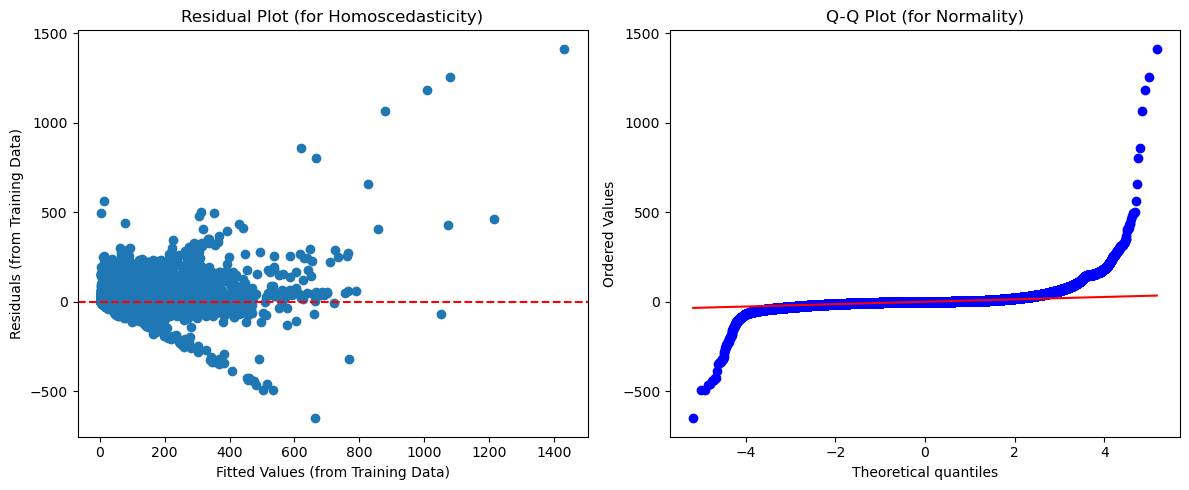

In [40]:
# Model B: Distance + Time
model2 = sm.OLS(yB_train, XB_train).fit()
pred2 = model2.predict(XB_test)
mae2 = mean_absolute_error(yB_test, pred2)
rmse2 = mean_squared_error(yB_test, pred2)

train_residuals2 = model2.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model2.fittedvalues, train_residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals2, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **Which model (A/B/C) do you pick and why?**  
Reference **Adjusted R²** (higher is better when comparing models with different numbers of predictors) and the **p-values**/signs of key coefficients.

2) **Business explanation:**  
Give a stakeholder-friendly summary in **units** (e.g., “+1 mile ≈ +$X in base fare, holding time constant”). If you added flags, explain their effect plainly. Mention any limitations (e.g., time vs distance confounding, missing columns).

Based solely on the results of the models, I would pick Model B. While Model C's additional flag variable did contribute more to the model (as told by our increased Adj. R-Squared), the contribution was not much at all. Furthermore, the confidence interal of our coefficients became less precise when we introduced our third flag variable, albeit a slight difference.

Looking particularly at the homoscedasticity, there does appear to be a cone shape. This is a limitation in the data, as this could indicate inconsistency in the variation of our y.

Overall, this model 

